# Модель ТВП участков ГТС

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import datetime

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Метрики
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


 ## поля датасета

- 'LineName' - имя участка,
- 'LineID' - номер участка в РТП,
- 'TFP' - технически возможная производительность млрд.м3/год, 
- 'Year' - год для которого внесены значения
- 'Age' - возраст участка, 
- 'Cur_age' - средний возраст по участку для текущего года, 
- 'Project_TFP' - проектная производительность,
- 'Days_repairs' - продолжительность ремонтных работ на участке в этом году,
- '1_year_repairs' - продолжительность ремонтных работ на этом участке годом ранее,
- '2_year_repairs' - продолжительность ремонтных работ на этом участке двумя годами ранее,
- 'Cur_flow' - величина фактического потока по участку в этом году,
- '1_year_flow' - величина фактического потока по участку годом ранее,
- '2_year_flow' - величина фактического потока по участку двумя годами ранее,
- 'Repairs_per_line' - среднее количество ремонтов (дней) на одну нитку в текущем году

In [2]:
df = pd.read_csv('./TFP.csv')

In [3]:
df.head(2)

,Unnamed: 0,Line_name,Line_ID,Age,Project_TFP,lines_counts,Year,TFP,Cur_flow,Days_repairs,Cur_age,1_year_repairs,2_year_repairs,1_year_flow,2_year_flow,Repairs_per_line
0,0,КС Ямбургская – КС Правохеттинская,1,1989.58,227.0,12,2012,173.0,NaN,NaN,22.42,NaN,NaN,NaN,NaN,NaN
1,1,КС Ямбургская – КС Правохеттинская,1,1989.58,227.0,12,2013,178.0,155.1,NaN,23.42,NaN,NaN,NaN,NaN,NaN


In [4]:
# df['Cur_age'] = df['Year'] - df['Age']

In [5]:
def func_1_year_repairs(ds):
    for u in df['Line_name'].unique().tolist():
        for i in df.loc[df['Line_name'] == u].index.tolist()[1:]:
            df.at[i, '1_year_repairs'] = df.loc[i-1, 'Days_repairs']

In [6]:
def func_2_year_repairs(ds):
    for u in df['Line_name'].unique().tolist():
        for i in df.loc[df['Line_name'] == u].index.tolist()[2:]:
            df.at[i, '2_year_repairs'] = df.loc[i-2, 'Days_repairs']

In [7]:
def func_1_year_flow(ds):
    for u in df['Line_name'].unique().tolist():
        for i in df.loc[df['Line_name'] == u].index.tolist()[1:]:
            df.at[i, '1_year_flow'] = df.loc[i-1, 'Cur_flow']

In [8]:
def func_2_year_flow(ds):
    for u in df['Line_name'].unique().tolist():
        for i in df.loc[df['Line_name'] == u].index.tolist()[2:]:
            df.at[i, '2_year_flow'] = df.loc[i-2, 'Cur_flow']

In [9]:
# func_1_year_repairs(df)
# func_2_year_repairs(df)
# func_1_year_flow(df)
# func_2_year_flow(df)

In [10]:
# df['Repairs_per_line'] = df['Days_repairs'] / df['lines_counts']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 16 columns):
Unnamed: 0          28 non-null int64
Line_name           28 non-null object
Line_ID             28 non-null int64
Age                 28 non-null float64
Project_TFP         28 non-null float64
lines_counts        28 non-null int64
Year                28 non-null int64
TFP                 28 non-null float64
Cur_flow            24 non-null float64
Days_repairs        16 non-null float64
Cur_age             28 non-null float64
1_year_repairs      12 non-null float64
2_year_repairs      8 non-null float64
1_year_flow         20 non-null float64
2_year_flow         16 non-null float64
Repairs_per_line    16 non-null float64
dtypes: float64(11), int64(4), object(1)
memory usage: 3.6+ KB


In [12]:
df.columns.tolist()

['Unnamed: 0',
 'Line_name',
 'Line_ID',
 'Age',
 'Project_TFP',
 'lines_counts',
 'Year',
 'TFP',
 'Cur_flow',
 'Days_repairs',
 'Cur_age',
 '1_year_repairs',
 '2_year_repairs',
 '1_year_flow',
 '2_year_flow',
 'Repairs_per_line']

In [13]:
features = ['Project_TFP',
 'lines_counts',
 'Year',
 'TFP',
 'Cur_flow',
 'Days_repairs',
 'Cur_age',
 '1_year_repairs',
 '2_year_repairs',
 '1_year_flow',
 '2_year_flow',
 'Repairs_per_line']

In [14]:
df_work = df[features]

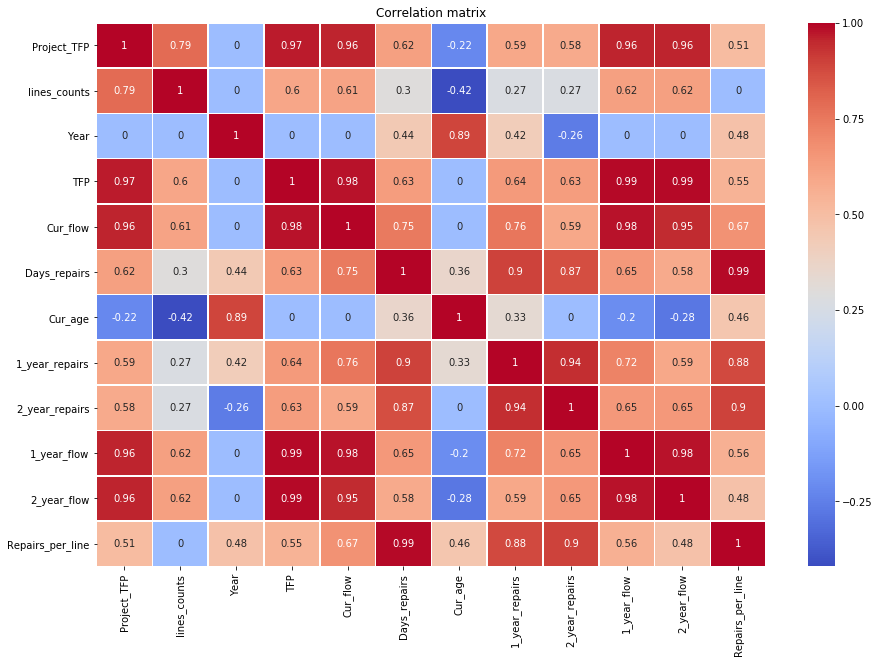

In [15]:
plt.figure(figsize=(15, 10))

corr_matrix = df_work.corr()
corr_matrix = np.round(corr_matrix, 2)

corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=0.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [16]:
df_work.columns.tolist()

['Project_TFP',
 'lines_counts',
 'Year',
 'TFP',
 'Cur_flow',
 'Days_repairs',
 'Cur_age',
 '1_year_repairs',
 '2_year_repairs',
 '1_year_flow',
 '2_year_flow',
 'Repairs_per_line']

In [25]:
features_names = ['Project_TFP',
 'lines_counts',
 'Year',
 'Cur_flow',
 'Days_repairs',
 'Cur_age',
 '1_year_repairs',
 '2_year_repairs',
 '1_year_flow',
 '2_year_flow',
 'Repairs_per_line']

In [26]:
target_name = 'TFP'

In [27]:
X = df_work[features_names]
y = df_work[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [28]:
# df.to_csv('./TFP.csv')

In [29]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print( "R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
            "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
            "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3))
          )
    plt.figure(figsize=(10, 10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    
    plt.show()

In [31]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)

# y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

R2:	-0.0
MSE:	9624.966
RMSE:	98.107


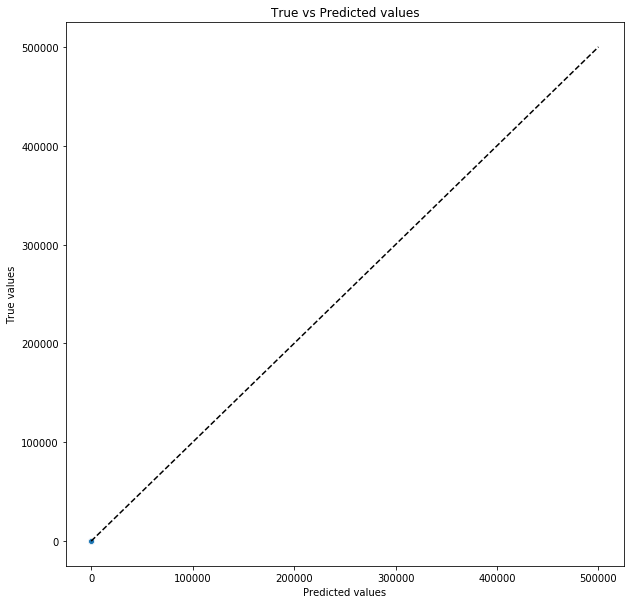

In [30]:
lgb_model = LGBMRegressor(criterion='mse',
                          max_depth=10,
                          min_samples_leaf=30,
                          random_state=42,
                          n_estimators=200)

lgb_model.fit(X_train, y_train)
y_train_preds = lgb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)